# Practical Machine Learning for Physicists
## Week 6 Exercise 
### Heather Tweedie, March 2023

In this notebook you will be trying to predict a system using incomplete information. We will set up the equations of motions for a simple double pendulum (or should that be a double simple pendulum. Then we will see if a machine learning technique can predict the future position of the lower mass, using only the lower mass positions.

### Kinematics of the double pendulum
Let's specify our problem in terms of the following, with the origin at the pivot point of the top pendulum. This is just background for the machine learning tasks at the bottom of the notebook.

#### Positions
$$x_1 = L_1 \sin \theta_1$$
$$y_1 = -L_1 \cos \theta_1$$
$$x_2 = x_1 + L_2 \sin \theta_2$$
$$y_2 = y_1 - L_2 \cos \theta_2$$

#### Velocities
$$\dot{x}_1 = \dot{\theta_1} L_1 \cos \theta_1$$
$$\dot{y_1} =  \dot{\theta_1} L_1 \sin \theta_1$$
$$\dot{x_2} = \dot{x_1} + \dot{\theta_2} L_2 \cos \theta_2$$
$$\dot{y_2} = \dot{y_1} + \dot{\theta_2} L_2 \sin \theta_2$$


#### Accelerations

$$\ddot{x}_1 = -\dot{\theta_1}^2 L_1 \sin \theta_1 + \ddot{\theta_1} L_1 \cos \theta_1$$
$$\ddot{y_1} =  \dot{\theta_1}^2 L_1 \cos \theta_1 + \ddot{\theta_1} L_1 \sin \theta_1$$
$$\ddot{x_2} = \ddot{x_1} - \dot{\theta_2}^2 L_2 \sin \theta_2 + \ddot{\theta_2} L_2 \cos \theta_2$$
$$\ddot{y_2} = \ddot{y_1} + \dot{\theta_2}^2 L_2 \cos \theta_2 + \ddot{\theta_2} L_2 \sin \theta_2$$

#### Energies
Let $v_1^2 = \dot{x_1}^2 +\dot{y_1}^2$ and $v_2^2 = \dot{x_2}^2 +\dot{y_2}^2$ then the kinetic energies $T_1$ and $T_2$ are
$$ T_1 = \frac{1}{2}m_1 v_1^2 = \frac{1}{2}m_1 L_1^2 \dot{\theta_1}^2 $$
$$ T_2 = \frac{1}{2}m_2 v_2^2 = \frac{1}{2}m_2 \left( L_1^2 \dot{\theta_1}^2 + L_2^2 \dot{\theta_2}^2 + 2L_1 L_2 \cos(\theta_1-\theta_2) \dot{\theta_1} \dot{\theta_2} \right) $$

The potential enrgies are
$$V_1 = m_1 g y_1 = - m_1 g L_1 \cos \theta_1$$
$$V_2 = m_2 g y_2 = -m_2 g ( L_1 \cos \theta_1 + L_2 \cos \theta_2)$$

#### Langrangian
Now we form the Lagrangian $L=T-V=T_1+T_2 -V_1 -V_2$ and use the Euler-Lagrange equations:
$$\frac{\partial L}{\partial \theta_1} = \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_1}}$$
$$\frac{\partial L}{\partial \theta_2} = \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_2}}$$

Applying these gives
$$-(m_1+m_2) g L_1 \sin \theta_1 = (m_1+m_2) L_1^2 \ddot{\theta_1} + m_2 L_1 L_2 \sin(\theta_1-\theta_2) \dot{\theta_2}^2 +  m_2 L_1 L_2 \cos(\theta_1-\theta_2) \ddot{\theta_2} $$
and
$$ -m_2 g L_2 \sin \theta_2 = m_2 L_2 \ddot{\theta_2} + m_2 L_1 L_2 \cos(\theta_1-\theta_2) \ddot{\theta_1} + m_2 L_1 L_2 \sin(\theta_1-\theta_2) \dot{\theta_1}^2 $$ 


#### Equations of motions
$$ \omega_1 = \dot{\theta_1}$$  

$$ \omega_2 = \dot{\theta_2}$$ 
$$ \ddot\theta_1 = \frac{1}{L_1\xi}\left[L_1m_2\cos(\theta_1-\theta_2)\sin(\theta_1-\theta_2)\omega_1^2 + L_2m_2\sin(\theta_1-\theta_2)\omega_2^2 - m_2g\cos(\theta_1-\theta_2)\sin(\theta_2) + (m_1+m_2)g\sin(\theta_1) \right] $$
$$ \ddot\theta_2 = \frac{1}{L_2\xi}\left[L_2m_2\cos(\theta_1-\theta_2)\sin(\theta_1-\theta_2)\omega_2^2 + L_1(m_1+m_2)\sin(\theta_1-\theta_2)\omega_1^2+(m_1+m_2)g\sin(\theta_1)\cos(\theta_1-\theta_2) - (m_1+m_2)g\sin(\theta_2) \right] $$
where 
$$\xi \equiv \cos^2(\theta_1-\theta_2)m_2-m_1-m_2$$


# Exercises: Predicting Chaos
1. Design and train a recurrent neural network (of your choice) to predict the future positions, where future is defined as $t=t_0 + 20 \delta t$, of the masses $m_1$ and $m_2$ using their cartesian coordinates and the initial conditions  $z_0=[\pi/4,0,\pi/4,0]$. 
2. How stable is your network to variations in initial conditions? Make a plot of $x$ and $y$ vs time to show the network prediction in comparison to the solution from solve_ivp
3. How far into the future can a network predict? Make a plot showing how the deviation between predicted position and actual position (from solve_ivp above) vary as a function of extrapolation time from $t=t_0 + 20 \delta t$ to $t=t_0 + 100 \delta t$  (e.g. for each extrapolation time, train a new version of the network and then plot the performance)
4. Repeat steps 1-3 for the initial conditions $z_0=[\pi/2,0,\pi/2,0]$ which give a much more complex path.
5. Repeat steps 1-4 but only train your neural network on the cartesian coordinates of the mass $m_2$ (i.e without showing your neural network the positions of the mass $m_1$)



In [155]:
import numpy as np
from numpy import concatenate
import matplotlib.pyplot as plt 
from scipy.integrate import solve_ivp

import matplotlib.style
import matplotlib as mpl

#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch

import tensorflow as tf
import keras
import keras.layers as layers

from tqdm import tqdm



Define functions for use in exercise:

In [156]:
def rhs(t, z, L1, L2, m1, m2, g):
    """
    Returns the right-hand side of the ordinary differential equation describing the double pendulem
    """
    theta1, w1, theta2, w2 = z    #The four components
    cos12 = np.cos(theta1 - theta2)
    sin12 = np.sin(theta1 - theta2)
    sin1 = np.sin(theta1)
    sin2 = np.sin(theta2)
    xi = cos12**2*m2 - m1 - m2
    w1dot = ( L1*m2*cos12*sin12*w1**2 + L2*m2*sin12*w2**2
            - m2*g*cos12*sin2      + (m1 + m2)*g*sin1)/(L1*xi)
    w2dot = -( L2*m2*cos12*sin12*w2**2 + L1*(m1 + m2)*sin12*w1**2
            + (m1 + m2)*g*sin1*cos12  - (m1 + m2)*g*sin2 )/(L2*xi)
    return w1, w1dot, w2, w2dot   #Return the w's and the wdot's




def to_cartesian(theta1, w1, theta2, w2, L1, L2):
    """ 
    Transforms theta and omega to cartesian coordinates and velocities x1, y1, x2, y2, vx1, vy1, vx2, vy2
    """
    x1 = L1 * np.sin(theta1)
    y1 = -L1 * np.cos(theta1)
    x2 = x1 + L2 * np.sin(theta2)
    y2 = y1 - L2 * np.cos(theta2)
    vx1 = L1*np.cos(theta1)*w1
    vy1 = L1*np.sin(theta1)*w1
    vx2 = vx1 + L2*np.cos(theta2)*w2
    vy2 = vy1 + L2*np.sin(theta2)*w2
    return x1, y1, x2, y2, vx1, vy1, vx2, vy2




def solve_pendulum(L1, L2, m1, m2, g, z0, t, tmax):
    """
    Calculates the x and y positions for a double pendulum system.
    
    Params:
        L1, L2: the lengths of masses one and two
        m1, m2: the masses of masses 1 and 2
        g: acceleration due to gravity
        z0: the starting angles of the pendulums
        t: the time array
        tmax: the max time to calculate to
    
    Returns:
        The cartesian coordinates and accelerations of the masses
    """
    
    # Solve initial value problem
    ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
    z = ret.y

    # Extract result
    theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
    return to_cartesian(theta1, w1, theta2, w2, L1, L2)




def shapeArray(x, windowSize, offset):
    """
    Splits up a 1-d array x into a series of overlapping windows.
    
    Params:
        x: the 1-d array to split
        windowSize: the number of samples used to train the network
        offset: the number of samples into the future to predict
        
    Returns:
        input, label: a tuple of the array of input windows and target (label) windows,
                each with dimensions (numberOfWindows, windowSize)
    """
    input = np.array([x[i : i + windowSize] for i in range(len(x) - (windowSize + offset) + 1)])
    label = np.array([x[i + windowSize : i + windowSize + offset] for i in range(len(x) - (windowSize + offset) + 1)])
    return (input, label[:,-1])




def train_model_both(x1, x2, y1, y2, windowSize, offset):
    """
    Trains a model on the positions of m1 and m2 with time.

    Params:
        windowSize: the size of window to split the data into
        offset: how far the model will predict
    
    Returns:
        The model, the x and y input values, the test data and the loss
    """

    # get input and label arrays   
    x1Input, x1Label = shapeArray(x1, windowSize, offset)
    x2Input, x2Label = shapeArray(x2, windowSize, offset)
    y1Input, y1Label = shapeArray(y1, windowSize, offset)
    y2Input, y2Label = shapeArray(y2, windowSize, offset)

    # reshape input and target arrays and divide into training and testing data
    input = np.concatenate( (x1Input, x2Input, y1Input, y2Input), axis = 1).reshape(*np.array(x1Input).shape, 4)
    input_train = input[0:345,:,:]
    input_test = input[346:-1,:,:]
    target = np.concatenate( (x1Label, x2Label, y1Label, y2Label)).reshape(len(x1Label), 4)
    target_train = target[0:345,:]
    target_test = target[346:-1,:]

    # define model
    model = keras.models.Sequential()
    model.add(layers.LSTM(16, input_shape = (None, 4), return_sequences = True)) # LSTM layer with 50 neurons
    model.add(layers.LSTM(8, activation = 'relu', return_sequences = False))
    model.add(layers.Dense(4, activation = "linear"))
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')

    model.summary()

    # train model and extract final loss
    history = model.fit(input_train, target_train, epochs = 30)
    cost = history.history['loss'][-1]

    return model, x1Input, x2Input, y1Input, y2Input, input_test, target_test, cost




def train_model_m2(x2, y2, windowSize, offset):
    """
    Trains a model on only the positions of m2 with time.

    Params:
        windowSize: the size of window to split the data into
        offset: how far the model will predict
    
    Returns:
        The model, the x and y input values, the test data and the loss
    """

    #Get our xInput and xLabel arrays    
    x2Input, x2Label = shapeArray(x2, windowSize, offset)
    y2Input, y2Label = shapeArray(y2, windowSize, offset)

    # reshape input and target arrays and divide into training and testing data
    input = np.concatenate( (x2Input, y2Input), axis = 1).reshape(*np.array(x2Input).shape, 2)
    input_train = input[0:345,:,:]
    input_test = input[346:-1,:,:]
    target = np.concatenate( (x2Label, y2Label)).reshape(len(x2Label), 2)
    target_train = target[0:345,:]
    target_test = target[346:-1,:]

    print(np.shape(input_train), np.shape(target_train))

    model = keras.models.Sequential()
    model.add(layers.LSTM(32, input_shape = (None, 2), return_sequences = True)) # LSTM layer with 50 neurons
    model.add(layers.LSTM(16, return_sequences = False))
    model.add(layers.Dense(128, activation = 'linear'))
    model.add(layers.Dense(2, activation = "linear"))
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')

    model.summary()

    history = model.fit(input_train, target_train, epochs = 30)
    cost = history.history['loss'][-1]

    return model, x2Input, y2Input, input_test, target_test, cost

    

## Training the network

Set initial conditions and solve ivp:

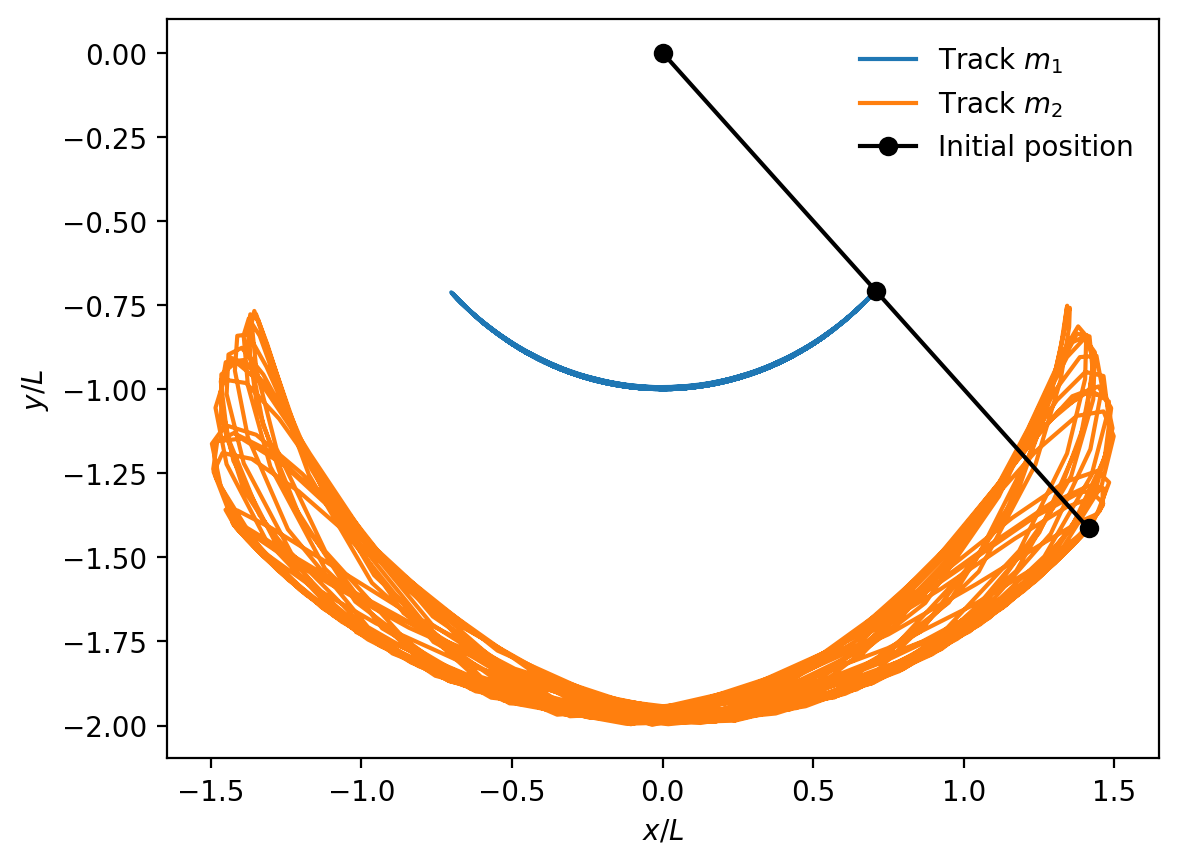

In [157]:
# set initial conditions
L1, L2 = 1., 1.                 # lengths, m
m1, m2 = 3., 1.                 # masses, kg
g = 9.81                        # gravitational acceleration, m/s^2 
z0 = [np.pi/4, 0, np.pi/4, 0]   # starting angles

# define time range
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt)

x1, y1, x2, y2, vx1, vy1, vx2, vy2 = solve_pendulum(L1, L2, m1, m2, g, z0, t, tmax)

fig, ax = plt.subplots()
ax.plot(x1, y1, label=r"Track $m_1$")
ax.plot(x2, y2, label=r"Track $m_2$")
ax.plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
plt.ylabel(r"$y/L$")
plt.xlabel(r"$x/L$")
ax.legend()

Train model and plot predictions for offset=20:

Model: "sequential_91"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_164 (LSTM)             (None, None, 16)          1344      
                                                                 
 lstm_165 (LSTM)             (None, 8)                 800       
                                                                 
 dense_149 (Dense)           (None, 4)                 36        
                                                                 
Total params: 2,180
Trainable params: 2,180
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 3s 28ms/step - loss: 0.8028
Epoch 2/30
11/11 [==============================] - 0s 24ms/step - loss: 0.7147
Epoch 3/30
11/11 [==============================] - 0s 22ms/step - loss: 0.7037
Epoch 4/30
11/11 [==============================] - 0s 22ms/step - loss: 0.

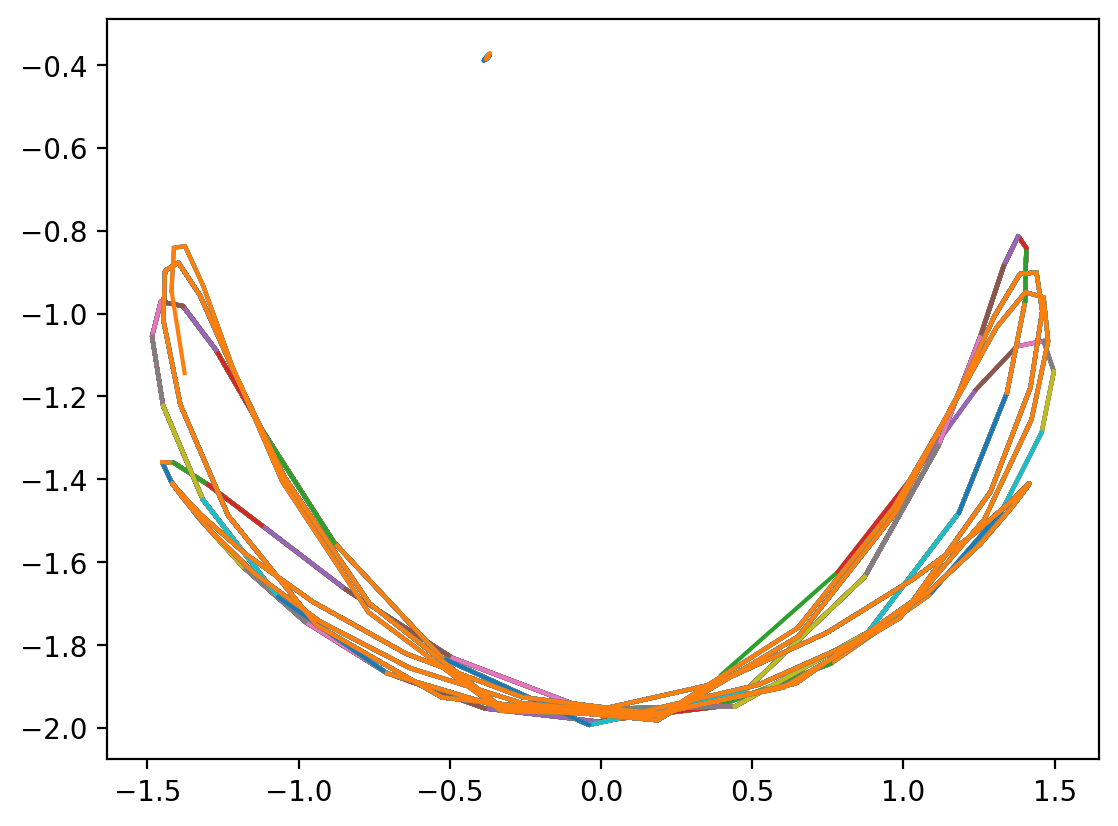

In [158]:
# set window size and offset
windowSize = 50
offset = 20

# train model and extract predictions
model, x1Input, x2Input, y1Input, y2Input, input_test, target_test, cost = train_model_both(x1, x2, y1, y2, windowSize, offset)
test_predict = model.predict(input_test)
predicted_x1 = test_predict[:,0]
predicted_x2 = test_predict[:,1]
predicted_y1 = test_predict[:,2]
predicted_y2 = test_predict[:,3]

# plot predicted and expected paths
fig, ax = plt.subplots()
ax.plot(predicted_x1, predicted_y1)
ax.plot(predicted_x2, predicted_y2)
ax.plot(x2Input[356:], y2Input[356:])


I really have no idea where this has gone so wrong and why the loss is so huge. Potentially an issue with the training/testing values?

## Varying the offset

Train the model on a range of offsets between 20 and 100, and plot loss.

  0%|          | 0/11 [00:00<?, ?it/s]

Model: "sequential_92"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_166 (LSTM)             (None, None, 16)          1344      
                                                                 
 lstm_167 (LSTM)             (None, 8)                 800       
                                                                 
 dense_150 (Dense)           (None, 4)                 36        
                                                                 
Total params: 2,180
Trainable params: 2,180
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 3s 20ms/step - loss: 0.7790
Epoch 2/30
11/11 [==============================] - 0s 23ms/step - loss: 0.7308
Epoch 3/30
11/11 [==============================] - 0s 21ms/step - loss: 0.7123
Epoch 4/30
11/11 [==============================] - 0s 21ms/step - loss: 0.

  9%|▉         | 1/11 [00:10<01:46, 10.63s/it]

Model: "sequential_93"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_168 (LSTM)             (None, None, 16)          1344      
                                                                 
 lstm_169 (LSTM)             (None, 8)                 800       
                                                                 
 dense_151 (Dense)           (None, 4)                 36        
                                                                 
Total params: 2,180
Trainable params: 2,180
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 3s 22ms/step - loss: 0.9551
Epoch 2/30
11/11 [==============================] - 0s 21ms/step - loss: 0.8508
Epoch 3/30
11/11 [==============================] - 0s 22ms/step - loss: 0.8333
Epoch 4/30
11/11 [==============================] - 0s 22ms/step - loss: 0.

 18%|█▊        | 2/11 [00:21<01:36, 10.68s/it]

Model: "sequential_94"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_170 (LSTM)             (None, None, 16)          1344      
                                                                 
 lstm_171 (LSTM)             (None, 8)                 800       
                                                                 
 dense_152 (Dense)           (None, 4)                 36        
                                                                 
Total params: 2,180
Trainable params: 2,180
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 3s 25ms/step - loss: 0.8802
Epoch 2/30
11/11 [==============================] - 0s 22ms/step - loss: 0.8691
Epoch 3/30
11/11 [==============================] - 0s 21ms/step - loss: 0.8577
Epoch 4/30
11/11 [==============================] - 0s 24ms/step - loss: 0.

 27%|██▋       | 3/11 [00:33<01:29, 11.18s/it]

Model: "sequential_95"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_172 (LSTM)             (None, None, 16)          1344      
                                                                 
 lstm_173 (LSTM)             (None, 8)                 800       
                                                                 
 dense_153 (Dense)           (None, 4)                 36        
                                                                 
Total params: 2,180
Trainable params: 2,180
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 6s 21ms/step - loss: 0.8712
Epoch 2/30
11/11 [==============================] - 0s 22ms/step - loss: 0.8105
Epoch 3/30
11/11 [==============================] - 0s 21ms/step - loss: 0.7747
Epoch 4/30
11/11 [==============================] - 0s 20ms/step - loss: 0.

 36%|███▋      | 4/11 [00:49<01:31, 13.07s/it]

Model: "sequential_96"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_174 (LSTM)             (None, None, 16)          1344      
                                                                 
 lstm_175 (LSTM)             (None, 8)                 800       
                                                                 
 dense_154 (Dense)           (None, 4)                 36        
                                                                 
Total params: 2,180
Trainable params: 2,180
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 3s 35ms/step - loss: 0.9315
Epoch 2/30
11/11 [==============================] - 0s 34ms/step - loss: 0.8810
Epoch 3/30
11/11 [==============================] - 0s 29ms/step - loss: 0.8613
Epoch 4/30
11/11 [==============================] - 0s 29ms/step - loss: 0.

 45%|████▌     | 5/11 [01:03<01:20, 13.50s/it]

Model: "sequential_97"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_176 (LSTM)             (None, None, 16)          1344      
                                                                 
 lstm_177 (LSTM)             (None, 8)                 800       
                                                                 
 dense_155 (Dense)           (None, 4)                 36        
                                                                 
Total params: 2,180
Trainable params: 2,180
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 3s 27ms/step - loss: 0.9143
Epoch 2/30
11/11 [==============================] - 0s 29ms/step - loss: 0.8779
Epoch 3/30
11/11 [==============================] - 0s 30ms/step - loss: 0.8437
Epoch 4/30
11/11 [==============================] - 0s 32ms/step - loss: 0.

 55%|█████▍    | 6/11 [01:16<01:07, 13.52s/it]

Model: "sequential_98"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_178 (LSTM)             (None, None, 16)          1344      
                                                                 
 lstm_179 (LSTM)             (None, 8)                 800       
                                                                 
 dense_156 (Dense)           (None, 4)                 36        
                                                                 
Total params: 2,180
Trainable params: 2,180
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 3s 27ms/step - loss: 0.9961
Epoch 2/30
11/11 [==============================] - 0s 31ms/step - loss: 0.8895
Epoch 3/30
11/11 [==============================] - 0s 32ms/step - loss: 0.8236
Epoch 4/30
11/11 [==============================] - 0s 31ms/step - loss: 0.

 64%|██████▎   | 7/11 [01:31<00:55, 13.77s/it]

Model: "sequential_99"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_180 (LSTM)             (None, None, 16)          1344      
                                                                 
 lstm_181 (LSTM)             (None, 8)                 800       
                                                                 
 dense_157 (Dense)           (None, 4)                 36        
                                                                 
Total params: 2,180
Trainable params: 2,180
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 3s 28ms/step - loss: 1.1340
Epoch 2/30
11/11 [==============================] - 0s 39ms/step - loss: 0.9810
Epoch 3/30
11/11 [==============================] - 0s 32ms/step - loss: 0.8951
Epoch 4/30
11/11 [==============================] - 0s 34ms/step - loss: 0.

 73%|███████▎  | 8/11 [01:45<00:42, 14.10s/it]

Model: "sequential_100"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_182 (LSTM)             (None, None, 16)          1344      
                                                                 
 lstm_183 (LSTM)             (None, 8)                 800       
                                                                 
 dense_158 (Dense)           (None, 4)                 36        
                                                                 
Total params: 2,180
Trainable params: 2,180
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 3s 26ms/step - loss: 1.0631
Epoch 2/30
11/11 [==============================] - 0s 29ms/step - loss: 1.0287
Epoch 3/30
11/11 [==============================] - 0s 30ms/step - loss: 0.9848
Epoch 4/30
11/11 [==============================] - 0s 32ms/step - loss: 0

 82%|████████▏ | 9/11 [01:59<00:27, 13.95s/it]

Model: "sequential_101"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_184 (LSTM)             (None, None, 16)          1344      
                                                                 
 lstm_185 (LSTM)             (None, 8)                 800       
                                                                 
 dense_159 (Dense)           (None, 4)                 36        
                                                                 
Total params: 2,180
Trainable params: 2,180
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 6s 36ms/step - loss: 0.9580
Epoch 2/30
11/11 [==============================] - 0s 34ms/step - loss: 0.9319
Epoch 3/30
11/11 [==============================] - 0s 33ms/step - loss: 0.9115
Epoch 4/30
11/11 [==============================] - 0s 35ms/step - loss: 0

 91%|█████████ | 10/11 [02:17<00:15, 15.19s/it]

Model: "sequential_102"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_186 (LSTM)             (None, None, 16)          1344      
                                                                 
 lstm_187 (LSTM)             (None, 8)                 800       
                                                                 
 dense_160 (Dense)           (None, 4)                 36        
                                                                 
Total params: 2,180
Trainable params: 2,180
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 3s 28ms/step - loss: 0.9641
Epoch 2/30
11/11 [==============================] - 0s 32ms/step - loss: 0.8662
Epoch 3/30
11/11 [==============================] - 0s 32ms/step - loss: 0.7964
Epoch 4/30
11/11 [==============================] - 0s 33ms/step - loss: 0

100%|██████████| 11/11 [02:31<00:00, 13.81s/it]


Text(0.5, 1.0, 'Accuracy of model trained on m1 and m2 for different offsets')

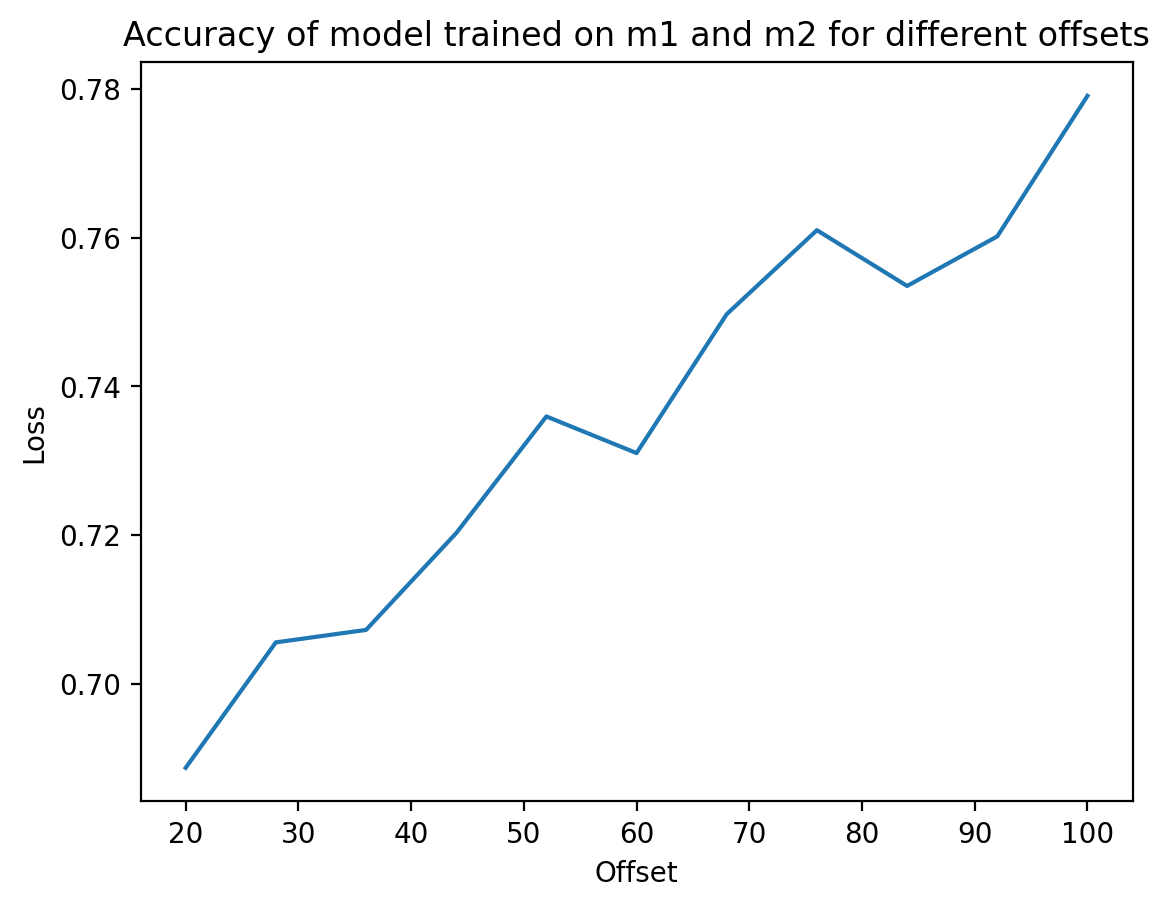

In [159]:
# set window size and offset, and initialise costs array
offsets = np.linspace(20,100,11)
windowSize = 50
costs = np.zeros(len(offsets))

# train model with each offset and extract predictions
for i in tqdm(range(len(offsets))):
    model, x1Input, x2Input, y1Input, y2Input, input_test, target_test, cost = train_model_both(x1, x2, y1, y2, windowSize, offsets[i].astype(int))
    test_predict = model.predict(input_test)
    predicted_x1 = test_predict[:,0]
    predicted_x2 = test_predict[:,1]
    predicted_y1 = test_predict[:,2]
    predicted_y2 = test_predict[:,3]
    costs[i] = cost

fig, ax = plt.subplots()
ax.plot(offsets, costs)
ax.set_xlabel("Offset")
ax.set_ylabel("Loss")
ax.set_title("Accuracy of model trained on m1 and m2 for different offsets")

Increasing the offset, i.e. increasing the distance into the future that the model predicts, increases the loss. The model is less accurate when it tries to predict further into the future.

Repeat for pendulum with starting positions $z_0=[\pi/2,0,\pi/2,0]$:

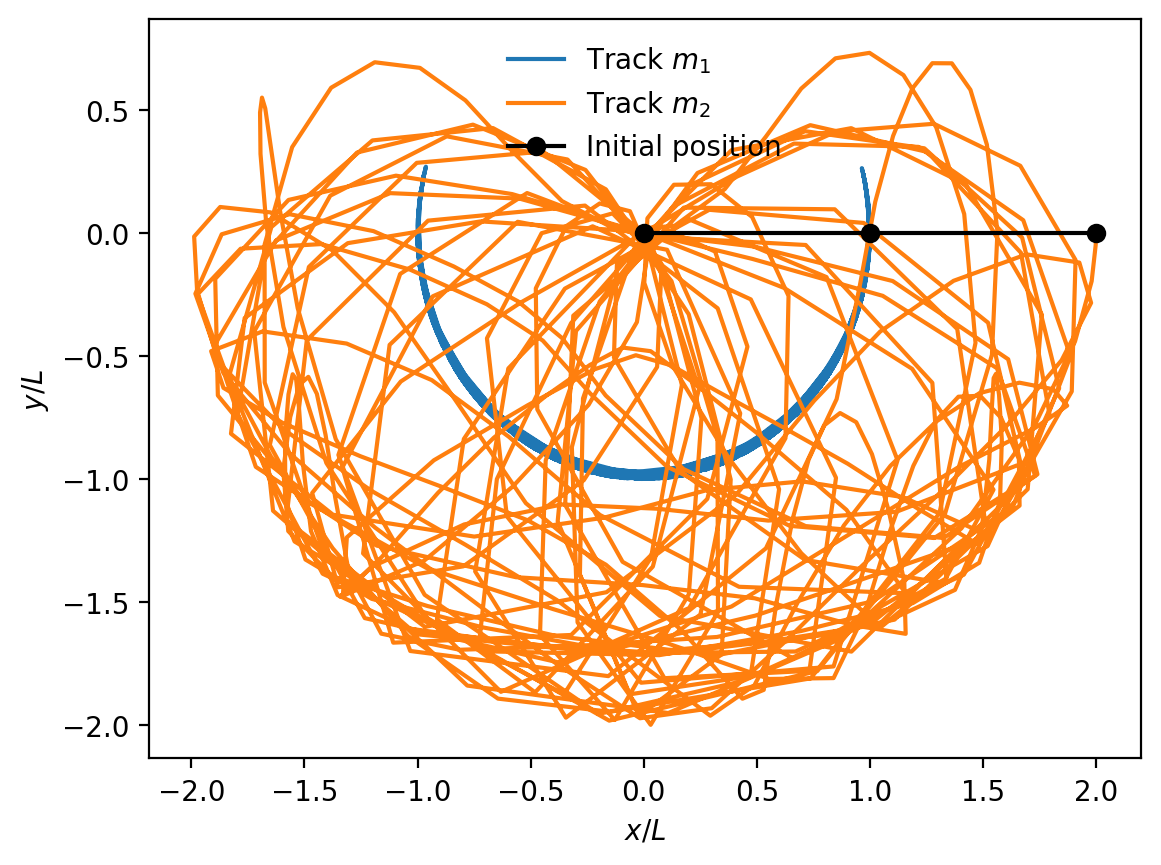

In [160]:
# set initial conditions
z0 = [np.pi/2, 0, np.pi/2, 0]   # starting angles

# re-calculate expected values
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = solve_pendulum(L1, L2, m1, m2, g, z0, t, tmax)

fig, ax = plt.subplots()
ax.plot(x1, y1, label=r"Track $m_1$")
ax.plot(x2, y2, label=r"Track $m_2$")
ax.plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
plt.ylabel(r"$y/L$")
plt.xlabel(r"$x/L$")
ax.legend()

Train the model on a range of offsets between 20 and 100, and plot loss.

  0%|          | 0/11 [00:00<?, ?it/s]

Model: "sequential_103"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_188 (LSTM)             (None, None, 16)          1344      
                                                                 
 lstm_189 (LSTM)             (None, 8)                 800       
                                                                 
 dense_161 (Dense)           (None, 4)                 36        
                                                                 
Total params: 2,180
Trainable params: 2,180
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 3s 26ms/step - loss: 0.7154
Epoch 2/30
11/11 [==============================] - 0s 28ms/step - loss: 0.6822
Epoch 3/30
11/11 [==============================] - 0s 29ms/step - loss: 0.6706
Epoch 4/30
11/11 [==============================] - 0s 30ms/step - loss: 0

  9%|▉         | 1/11 [00:13<02:12, 13.27s/it]

Model: "sequential_104"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_190 (LSTM)             (None, None, 16)          1344      
                                                                 
 lstm_191 (LSTM)             (None, 8)                 800       
                                                                 
 dense_162 (Dense)           (None, 4)                 36        
                                                                 
Total params: 2,180
Trainable params: 2,180
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 3s 26ms/step - loss: 0.7410
Epoch 2/30
11/11 [==============================] - 0s 29ms/step - loss: 0.7092
Epoch 3/30
11/11 [==============================] - 0s 30ms/step - loss: 0.7053
Epoch 4/30
11/11 [==============================] - 0s 29ms/step - loss: 0

 18%|█▊        | 2/11 [00:26<01:57, 13.03s/it]

Model: "sequential_105"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_192 (LSTM)             (None, None, 16)          1344      
                                                                 
 lstm_193 (LSTM)             (None, 8)                 800       
                                                                 
 dense_163 (Dense)           (None, 4)                 36        
                                                                 
Total params: 2,180
Trainable params: 2,180
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 2s 22ms/step - loss: 0.7348
Epoch 2/30
11/11 [==============================] - 0s 22ms/step - loss: 0.7041
Epoch 3/30
11/11 [==============================] - 0s 24ms/step - loss: 0.6901
Epoch 4/30
11/11 [==============================] - 0s 27ms/step - loss: 0

 27%|██▋       | 3/11 [00:38<01:40, 12.61s/it]

Model: "sequential_106"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_194 (LSTM)             (None, None, 16)          1344      
                                                                 
 lstm_195 (LSTM)             (None, 8)                 800       
                                                                 
 dense_164 (Dense)           (None, 4)                 36        
                                                                 
Total params: 2,180
Trainable params: 2,180
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 2s 23ms/step - loss: 0.7629
Epoch 2/30
11/11 [==============================] - 0s 26ms/step - loss: 0.7397
Epoch 3/30
11/11 [==============================] - 0s 27ms/step - loss: 0.7351
Epoch 4/30
11/11 [==============================] - 0s 28ms/step - loss: 0

 36%|███▋      | 4/11 [00:50<01:26, 12.39s/it]

Model: "sequential_107"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_196 (LSTM)             (None, None, 16)          1344      
                                                                 
 lstm_197 (LSTM)             (None, 8)                 800       
                                                                 
 dense_165 (Dense)           (None, 4)                 36        
                                                                 
Total params: 2,180
Trainable params: 2,180
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 5s 22ms/step - loss: 0.7266
Epoch 2/30
11/11 [==============================] - 0s 22ms/step - loss: 0.7052
Epoch 3/30
11/11 [==============================] - 0s 23ms/step - loss: 0.6881
Epoch 4/30
11/11 [==============================] - 0s 22ms/step - loss: 0

 45%|████▌     | 5/11 [01:05<01:19, 13.24s/it]

Model: "sequential_108"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_198 (LSTM)             (None, None, 16)          1344      
                                                                 
 lstm_199 (LSTM)             (None, 8)                 800       
                                                                 
 dense_166 (Dense)           (None, 4)                 36        
                                                                 
Total params: 2,180
Trainable params: 2,180
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 3s 23ms/step - loss: 0.7693
Epoch 2/30
11/11 [==============================] - 0s 26ms/step - loss: 0.7196
Epoch 3/30
11/11 [==============================] - 0s 28ms/step - loss: 0.6956
Epoch 4/30
11/11 [==============================] - 0s 28ms/step - loss: 0

 55%|█████▍    | 6/11 [01:17<01:05, 13.05s/it]

Model: "sequential_109"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_200 (LSTM)             (None, None, 16)          1344      
                                                                 
 lstm_201 (LSTM)             (None, 8)                 800       
                                                                 
 dense_167 (Dense)           (None, 4)                 36        
                                                                 
Total params: 2,180
Trainable params: 2,180
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 3s 25ms/step - loss: 0.7605
Epoch 2/30
11/11 [==============================] - 0s 27ms/step - loss: 0.7257
Epoch 3/30
11/11 [==============================] - 0s 29ms/step - loss: 0.7073
Epoch 4/30
11/11 [==============================] - 0s 29ms/step - loss: 0

 64%|██████▎   | 7/11 [01:30<00:51, 12.93s/it]

Model: "sequential_110"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_202 (LSTM)             (None, None, 16)          1344      
                                                                 
 lstm_203 (LSTM)             (None, 8)                 800       
                                                                 
 dense_168 (Dense)           (None, 4)                 36        
                                                                 
Total params: 2,180
Trainable params: 2,180
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 3s 26ms/step - loss: 0.8184
Epoch 2/30
11/11 [==============================] - 0s 28ms/step - loss: 0.7708
Epoch 3/30
11/11 [==============================] - 0s 29ms/step - loss: 0.7582
Epoch 4/30
11/11 [==============================] - 0s 28ms/step - loss: 0

 73%|███████▎  | 8/11 [01:42<00:38, 12.79s/it]

Model: "sequential_111"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_204 (LSTM)             (None, None, 16)          1344      
                                                                 
 lstm_205 (LSTM)             (None, 8)                 800       
                                                                 
 dense_169 (Dense)           (None, 4)                 36        
                                                                 
Total params: 2,180
Trainable params: 2,180
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 3s 27ms/step - loss: 0.8870
Epoch 2/30
11/11 [==============================] - 0s 28ms/step - loss: 0.8113
Epoch 3/30
11/11 [==============================] - 0s 29ms/step - loss: 0.7942
Epoch 4/30
11/11 [==============================] - 0s 29ms/step - loss: 0

 82%|████████▏ | 9/11 [01:55<00:25, 12.73s/it]

Model: "sequential_112"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_206 (LSTM)             (None, None, 16)          1344      
                                                                 
 lstm_207 (LSTM)             (None, 8)                 800       
                                                                 
 dense_170 (Dense)           (None, 4)                 36        
                                                                 
Total params: 2,180
Trainable params: 2,180
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 2s 24ms/step - loss: 0.8056
Epoch 2/30
11/11 [==============================] - 0s 35ms/step - loss: 0.7965
Epoch 3/30
11/11 [==============================] - 0s 29ms/step - loss: 0.7781
Epoch 4/30
11/11 [==============================] - 0s 29ms/step - loss: 0

 91%|█████████ | 10/11 [02:07<00:12, 12.65s/it]

Model: "sequential_113"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_208 (LSTM)             (None, None, 16)          1344      
                                                                 
 lstm_209 (LSTM)             (None, 8)                 800       
                                                                 
 dense_171 (Dense)           (None, 4)                 36        
                                                                 
Total params: 2,180
Trainable params: 2,180
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 5s 28ms/step - loss: 0.9986
Epoch 2/30
11/11 [==============================] - 0s 35ms/step - loss: 0.8563
Epoch 3/30
11/11 [==============================] - 0s 46ms/step - loss: 0.8013
Epoch 4/30
11/11 [==============================] - 0s 37ms/step - loss: 0

100%|██████████| 11/11 [02:24<00:00, 13.17s/it]


Text(0, 0.5, 'Loss')

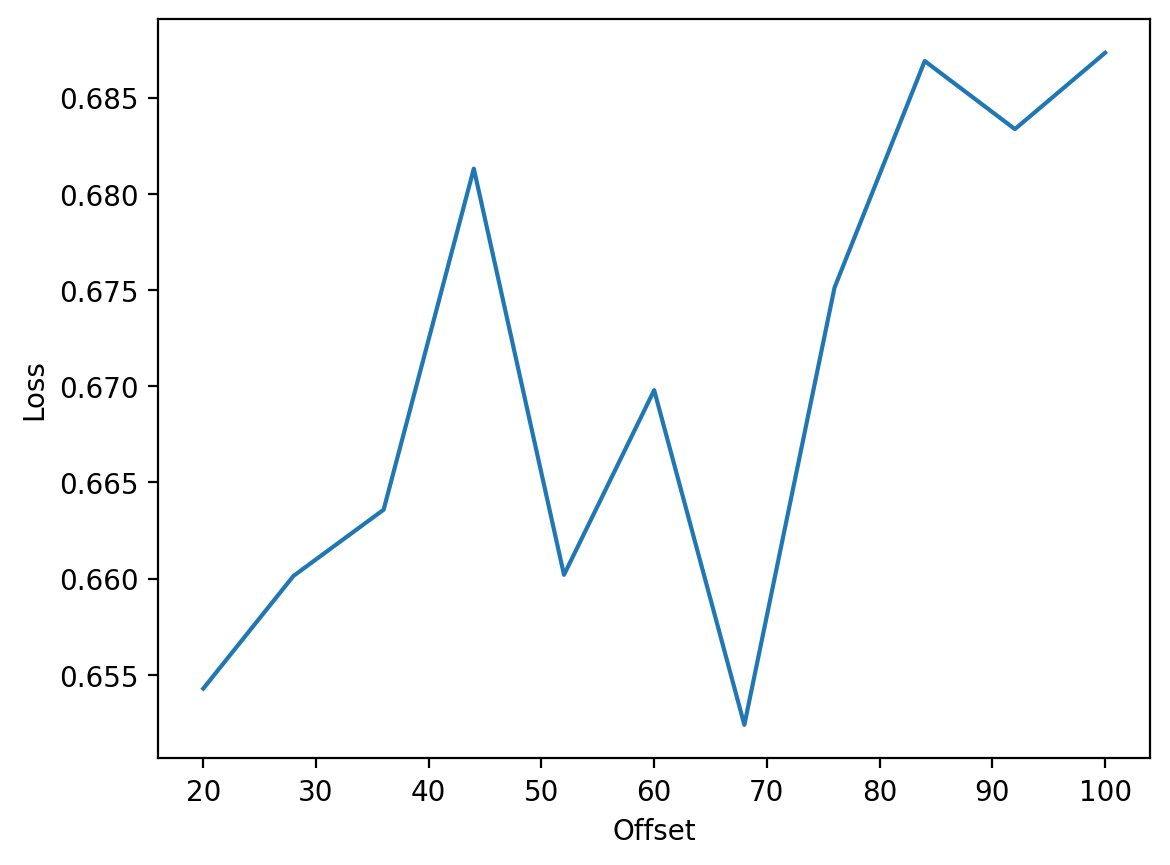

In [161]:
# set window size and offset, and initialise costs array
offsets = np.linspace(20,100,11)
windowSize = 50
costs = np.zeros(len(offsets))

# train model with each offset and extract predictions
for i in tqdm(range(len(offsets))):
    model, x1Input, x2Input, y1Input, y2Input, input_test, target_test, cost = train_model_both(x1, x2, y1, y2, windowSize, offsets[i].astype(int))
    test_predict = model.predict(input_test)
    predicted_x1 = test_predict[:,0]
    predicted_x2 = test_predict[:,1]
    predicted_y1 = test_predict[:,2]
    predicted_y2 = test_predict[:,3]
    costs[i] = cost

fig, ax = plt.subplots()
ax.plot(offsets, costs)
ax.set_xlabel("Offset")
ax.set_ylabel("Loss")

The loss for the more chaotic pendulum does not vary much with offset and does not follow any particular pattern, but is very variable.

## Train with only m2

Train the model using only the positions of m2:

In [162]:
# set initial conditions
z0 = [np.pi/4, 0, np.pi/4, 0]   # starting angles

# re-calculate expected values
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = solve_pendulum(L1, L2, m1, m2, g, z0, t, tmax)

Train the model on a range of offsets between 20 and 100, and plot loss:

  0%|          | 0/11 [00:00<?, ?it/s]

(345, 50, 2) (345, 2)
Model: "sequential_114"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_210 (LSTM)             (None, None, 32)          4480      
                                                                 
 lstm_211 (LSTM)             (None, 16)                3136      
                                                                 
 dense_172 (Dense)           (None, 128)               2176      
                                                                 
 dense_173 (Dense)           (None, 2)                 258       
                                                                 
Total params: 10,050
Trainable params: 10,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 3s 31ms/step - loss: 1.3467
Epoch 2/30
11/11 [==============================] - 0s 32ms/step - loss: 1.318

  9%|▉         | 1/11 [00:15<02:32, 15.21s/it]

(345, 50, 2) (345, 2)
Model: "sequential_115"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_212 (LSTM)             (None, None, 32)          4480      
                                                                 
 lstm_213 (LSTM)             (None, 16)                3136      
                                                                 
 dense_174 (Dense)           (None, 128)               2176      
                                                                 
 dense_175 (Dense)           (None, 2)                 258       
                                                                 
Total params: 10,050
Trainable params: 10,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 3s 27ms/step - loss: 1.3409
Epoch 2/30
11/11 [==============================] - 0s 31ms/step - loss: 1.350

 18%|█▊        | 2/11 [00:29<02:11, 14.63s/it]

(345, 50, 2) (345, 2)
Model: "sequential_116"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_214 (LSTM)             (None, None, 32)          4480      
                                                                 
 lstm_215 (LSTM)             (None, 16)                3136      
                                                                 
 dense_176 (Dense)           (None, 128)               2176      
                                                                 
 dense_177 (Dense)           (None, 2)                 258       
                                                                 
Total params: 10,050
Trainable params: 10,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 3s 30ms/step - loss: 1.3389
Epoch 2/30
11/11 [==============================] - 0s 37ms/step - loss: 1.320

 27%|██▋       | 3/11 [00:43<01:55, 14.43s/it]

(345, 50, 2) (345, 2)
Model: "sequential_117"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_216 (LSTM)             (None, None, 32)          4480      
                                                                 
 lstm_217 (LSTM)             (None, 16)                3136      
                                                                 
 dense_178 (Dense)           (None, 128)               2176      
                                                                 
 dense_179 (Dense)           (None, 2)                 258       
                                                                 
Total params: 10,050
Trainable params: 10,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 3s 27ms/step - loss: 1.4218
Epoch 2/30
11/11 [==============================] - 0s 29ms/step - loss: 1.302

 36%|███▋      | 4/11 [00:57<01:39, 14.22s/it]

(345, 50, 2) (345, 2)
Model: "sequential_118"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_218 (LSTM)             (None, None, 32)          4480      
                                                                 
 lstm_219 (LSTM)             (None, 16)                3136      
                                                                 
 dense_180 (Dense)           (None, 128)               2176      
                                                                 
 dense_181 (Dense)           (None, 2)                 258       
                                                                 
Total params: 10,050
Trainable params: 10,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 5s 26ms/step - loss: 1.4477
Epoch 2/30
11/11 [==============================] - 0s 25ms/step - loss: 1.299

 45%|████▌     | 5/11 [01:13<01:29, 14.88s/it]

(345, 50, 2) (345, 2)
Model: "sequential_119"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_220 (LSTM)             (None, None, 32)          4480      
                                                                 
 lstm_221 (LSTM)             (None, 16)                3136      
                                                                 
 dense_182 (Dense)           (None, 128)               2176      
                                                                 
 dense_183 (Dense)           (None, 2)                 258       
                                                                 
Total params: 10,050
Trainable params: 10,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 3s 25ms/step - loss: 1.4680
Epoch 2/30
11/11 [==============================] - 0s 46ms/step - loss: 1.276

 55%|█████▍    | 6/11 [01:29<01:16, 15.36s/it]

(345, 50, 2) (345, 2)
Model: "sequential_120"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_222 (LSTM)             (None, None, 32)          4480      
                                                                 
 lstm_223 (LSTM)             (None, 16)                3136      
                                                                 
 dense_184 (Dense)           (None, 128)               2176      
                                                                 
 dense_185 (Dense)           (None, 2)                 258       
                                                                 
Total params: 10,050
Trainable params: 10,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 3s 36ms/step - loss: 1.3584
Epoch 2/30
11/11 [==============================] - 0s 40ms/step - loss: 1.280

 64%|██████▎   | 7/11 [01:48<01:05, 16.47s/it]

(345, 50, 2) (345, 2)
Model: "sequential_121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_224 (LSTM)             (None, None, 32)          4480      
                                                                 
 lstm_225 (LSTM)             (None, 16)                3136      
                                                                 
 dense_186 (Dense)           (None, 128)               2176      
                                                                 
 dense_187 (Dense)           (None, 2)                 258       
                                                                 
Total params: 10,050
Trainable params: 10,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 4s 29ms/step - loss: 1.3966
Epoch 2/30
11/11 [==============================] - 0s 32ms/step - loss: 1.292

 73%|███████▎  | 8/11 [02:04<00:48, 16.19s/it]

(345, 50, 2) (345, 2)
Model: "sequential_122"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_226 (LSTM)             (None, None, 32)          4480      
                                                                 
 lstm_227 (LSTM)             (None, 16)                3136      
                                                                 
 dense_188 (Dense)           (None, 128)               2176      
                                                                 
 dense_189 (Dense)           (None, 2)                 258       
                                                                 
Total params: 10,050
Trainable params: 10,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 3s 31ms/step - loss: 1.5070
Epoch 2/30
11/11 [==============================] - 0s 35ms/step - loss: 1.248

 82%|████████▏ | 9/11 [02:22<00:33, 16.96s/it]

(345, 50, 2) (345, 2)
Model: "sequential_123"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_228 (LSTM)             (None, None, 32)          4480      
                                                                 
 lstm_229 (LSTM)             (None, 16)                3136      
                                                                 
 dense_190 (Dense)           (None, 128)               2176      
                                                                 
 dense_191 (Dense)           (None, 2)                 258       
                                                                 
Total params: 10,050
Trainable params: 10,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 4s 31ms/step - loss: 1.4372
Epoch 2/30
11/11 [==============================] - 0s 34ms/step - loss: 1.245

 91%|█████████ | 10/11 [02:39<00:16, 16.82s/it]

(345, 50, 2) (345, 2)
Model: "sequential_124"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_230 (LSTM)             (None, None, 32)          4480      
                                                                 
 lstm_231 (LSTM)             (None, 16)                3136      
                                                                 
 dense_192 (Dense)           (None, 128)               2176      
                                                                 
 dense_193 (Dense)           (None, 2)                 258       
                                                                 
Total params: 10,050
Trainable params: 10,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 5s 37ms/step - loss: 1.4583
Epoch 2/30
11/11 [==============================] - 0s 36ms/step - loss: 1.251

100%|██████████| 11/11 [02:56<00:00, 16.08s/it]


Text(0.5, 1.0, 'Accuracy of model trained on m2 for different offsets')

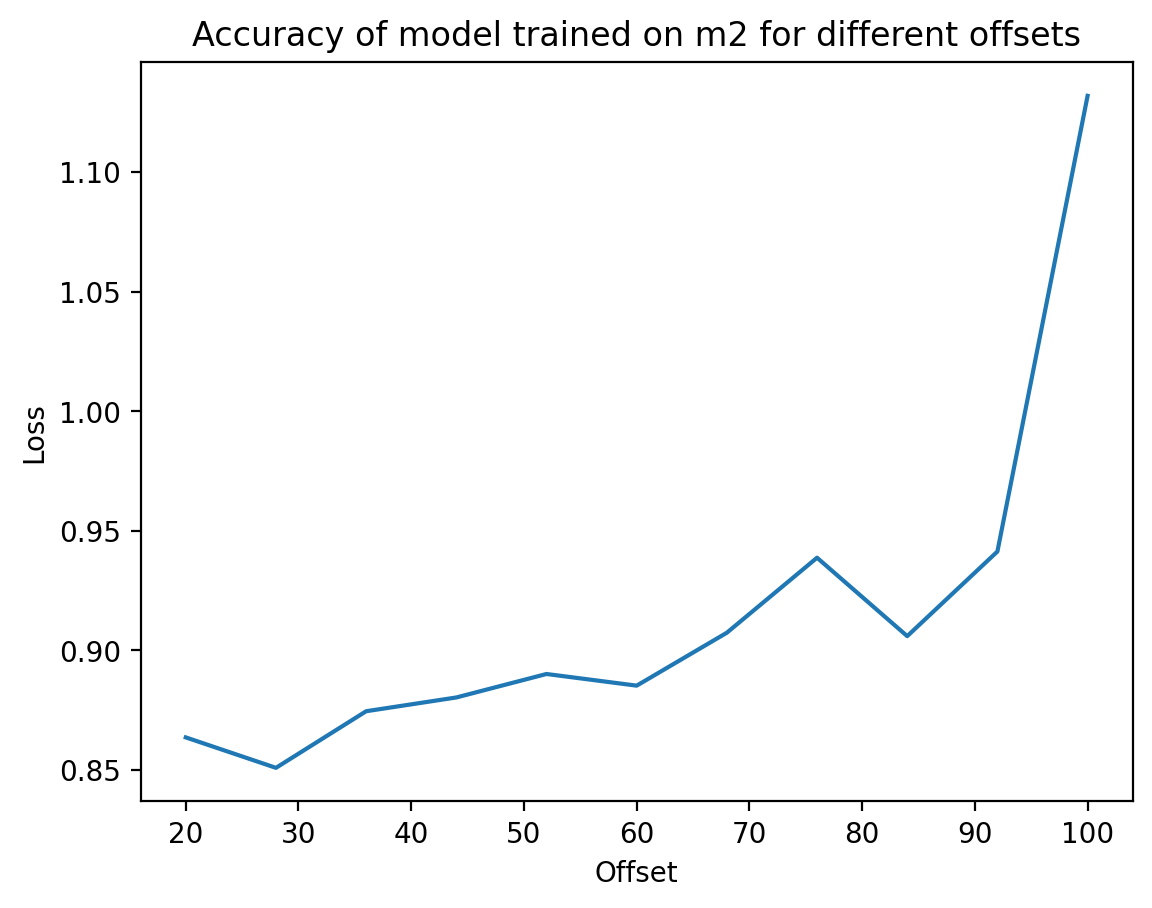

In [163]:
offsets = np.linspace(20,100,11)
windowSize = 50
costs = np.zeros(len(offsets))

for i in tqdm(range(len(offsets))):
    model, x2Input, y2Input, input_test, target_test, cost = train_model_m2(x2, y2, windowSize, offsets[i].astype(int))
    test_predict = model.predict(input_test)
    predicted_x2 = test_predict[:,0]
    predicted_y2 = test_predict[:,1]
    costs[i] = cost

fig, ax = plt.subplots()
ax.plot(offsets, costs)
ax.set_xlabel("Offset")
ax.set_ylabel("Loss")
ax.set_title("Accuracy of model trained on m2 for different offsets")

In [164]:
# set initial conditions
z0 = [np.pi/2, 0, np.pi/2, 0]   # starting angles

# re-calculate expected values
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = solve_pendulum(L1, L2, m1, m2, g, z0, t, tmax)

  0%|          | 0/11 [00:00<?, ?it/s]

(345, 50, 2) (345, 2)
Model: "sequential_125"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_232 (LSTM)             (None, None, 32)          4480      
                                                                 
 lstm_233 (LSTM)             (None, 16)                3136      
                                                                 
 dense_194 (Dense)           (None, 128)               2176      
                                                                 
 dense_195 (Dense)           (None, 2)                 258       
                                                                 
Total params: 10,050
Trainable params: 10,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 3s 29ms/step - loss: 1.0758
Epoch 2/30
11/11 [==============================] - 0s 36ms/step - loss: 1.012

  9%|▉         | 1/11 [00:15<02:31, 15.14s/it]

(345, 50, 2) (345, 2)
Model: "sequential_126"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_234 (LSTM)             (None, None, 32)          4480      
                                                                 
 lstm_235 (LSTM)             (None, 16)                3136      
                                                                 
 dense_196 (Dense)           (None, 128)               2176      
                                                                 
 dense_197 (Dense)           (None, 2)                 258       
                                                                 
Total params: 10,050
Trainable params: 10,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 3s 28ms/step - loss: 1.0810
Epoch 2/30
11/11 [==============================] - 0s 34ms/step - loss: 1.008

 18%|█▊        | 2/11 [00:30<02:15, 15.01s/it]

(345, 50, 2) (345, 2)
Model: "sequential_127"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_236 (LSTM)             (None, None, 32)          4480      
                                                                 
 lstm_237 (LSTM)             (None, 16)                3136      
                                                                 
 dense_198 (Dense)           (None, 128)               2176      
                                                                 
 dense_199 (Dense)           (None, 2)                 258       
                                                                 
Total params: 10,050
Trainable params: 10,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 6s 32ms/step - loss: 1.0540
Epoch 2/30
11/11 [==============================] - 0s 26ms/step - loss: 1.004

 27%|██▋       | 3/11 [00:47<02:08, 16.01s/it]

(345, 50, 2) (345, 2)
Model: "sequential_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_238 (LSTM)             (None, None, 32)          4480      
                                                                 
 lstm_239 (LSTM)             (None, 16)                3136      
                                                                 
 dense_200 (Dense)           (None, 128)               2176      
                                                                 
 dense_201 (Dense)           (None, 2)                 258       
                                                                 
Total params: 10,050
Trainable params: 10,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 4s 33ms/step - loss: 1.0201
Epoch 2/30
11/11 [==============================] - 0s 44ms/step - loss: 1.021

 36%|███▋      | 4/11 [01:04<01:55, 16.51s/it]

(345, 50, 2) (345, 2)
Model: "sequential_129"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_240 (LSTM)             (None, None, 32)          4480      
                                                                 
 lstm_241 (LSTM)             (None, 16)                3136      
                                                                 
 dense_202 (Dense)           (None, 128)               2176      
                                                                 
 dense_203 (Dense)           (None, 2)                 258       
                                                                 
Total params: 10,050
Trainable params: 10,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 3s 32ms/step - loss: 1.0492
Epoch 2/30
11/11 [==============================] - 0s 35ms/step - loss: 1.004

 45%|████▌     | 5/11 [01:21<01:39, 16.55s/it]

(345, 50, 2) (345, 2)
Model: "sequential_130"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_242 (LSTM)             (None, None, 32)          4480      
                                                                 
 lstm_243 (LSTM)             (None, 16)                3136      
                                                                 
 dense_204 (Dense)           (None, 128)               2176      
                                                                 
 dense_205 (Dense)           (None, 2)                 258       
                                                                 
Total params: 10,050
Trainable params: 10,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 3s 33ms/step - loss: 1.0433
Epoch 2/30
11/11 [==============================] - 0s 35ms/step - loss: 1.013

 55%|█████▍    | 6/11 [01:37<01:22, 16.51s/it]

(345, 50, 2) (345, 2)
Model: "sequential_131"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_244 (LSTM)             (None, None, 32)          4480      
                                                                 
 lstm_245 (LSTM)             (None, 16)                3136      
                                                                 
 dense_206 (Dense)           (None, 128)               2176      
                                                                 
 dense_207 (Dense)           (None, 2)                 258       
                                                                 
Total params: 10,050
Trainable params: 10,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 3s 33ms/step - loss: 1.0537
Epoch 2/30
11/11 [==============================] - 0s 36ms/step - loss: 0.980

 64%|██████▎   | 7/11 [01:54<01:06, 16.54s/it]

(345, 50, 2) (345, 2)
Model: "sequential_132"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_246 (LSTM)             (None, None, 32)          4480      
                                                                 
 lstm_247 (LSTM)             (None, 16)                3136      
                                                                 
 dense_208 (Dense)           (None, 128)               2176      
                                                                 
 dense_209 (Dense)           (None, 2)                 258       
                                                                 
Total params: 10,050
Trainable params: 10,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 6s 37ms/step - loss: 1.0008
Epoch 2/30
11/11 [==============================] - 0s 36ms/step - loss: 0.997

 73%|███████▎  | 8/11 [02:13<00:52, 17.39s/it]

(345, 50, 2) (345, 2)
Model: "sequential_133"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_248 (LSTM)             (None, None, 32)          4480      
                                                                 
 lstm_249 (LSTM)             (None, 16)                3136      
                                                                 
 dense_210 (Dense)           (None, 128)               2176      
                                                                 
 dense_211 (Dense)           (None, 2)                 258       
                                                                 
Total params: 10,050
Trainable params: 10,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 3s 34ms/step - loss: 1.0545
Epoch 2/30
11/11 [==============================] - 0s 35ms/step - loss: 0.989

 82%|████████▏ | 9/11 [02:30<00:34, 17.18s/it]

(345, 50, 2) (345, 2)
Model: "sequential_134"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_250 (LSTM)             (None, None, 32)          4480      
                                                                 
 lstm_251 (LSTM)             (None, 16)                3136      
                                                                 
 dense_212 (Dense)           (None, 128)               2176      
                                                                 
 dense_213 (Dense)           (None, 2)                 258       
                                                                 
Total params: 10,050
Trainable params: 10,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 3s 32ms/step - loss: 1.0555
Epoch 2/30
11/11 [==============================] - 0s 36ms/step - loss: 0.970

 91%|█████████ | 10/11 [02:46<00:16, 16.92s/it]

(345, 50, 2) (345, 2)
Model: "sequential_135"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_252 (LSTM)             (None, None, 32)          4480      
                                                                 
 lstm_253 (LSTM)             (None, 16)                3136      
                                                                 
 dense_214 (Dense)           (None, 128)               2176      
                                                                 
 dense_215 (Dense)           (None, 2)                 258       
                                                                 
Total params: 10,050
Trainable params: 10,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 3s 36ms/step - loss: 1.0810
Epoch 2/30
11/11 [==============================] - 0s 35ms/step - loss: 0.976

100%|██████████| 11/11 [03:02<00:00, 16.62s/it]


Text(0.5, 1.0, 'Accuracy of model trained on m2 for different offsets')

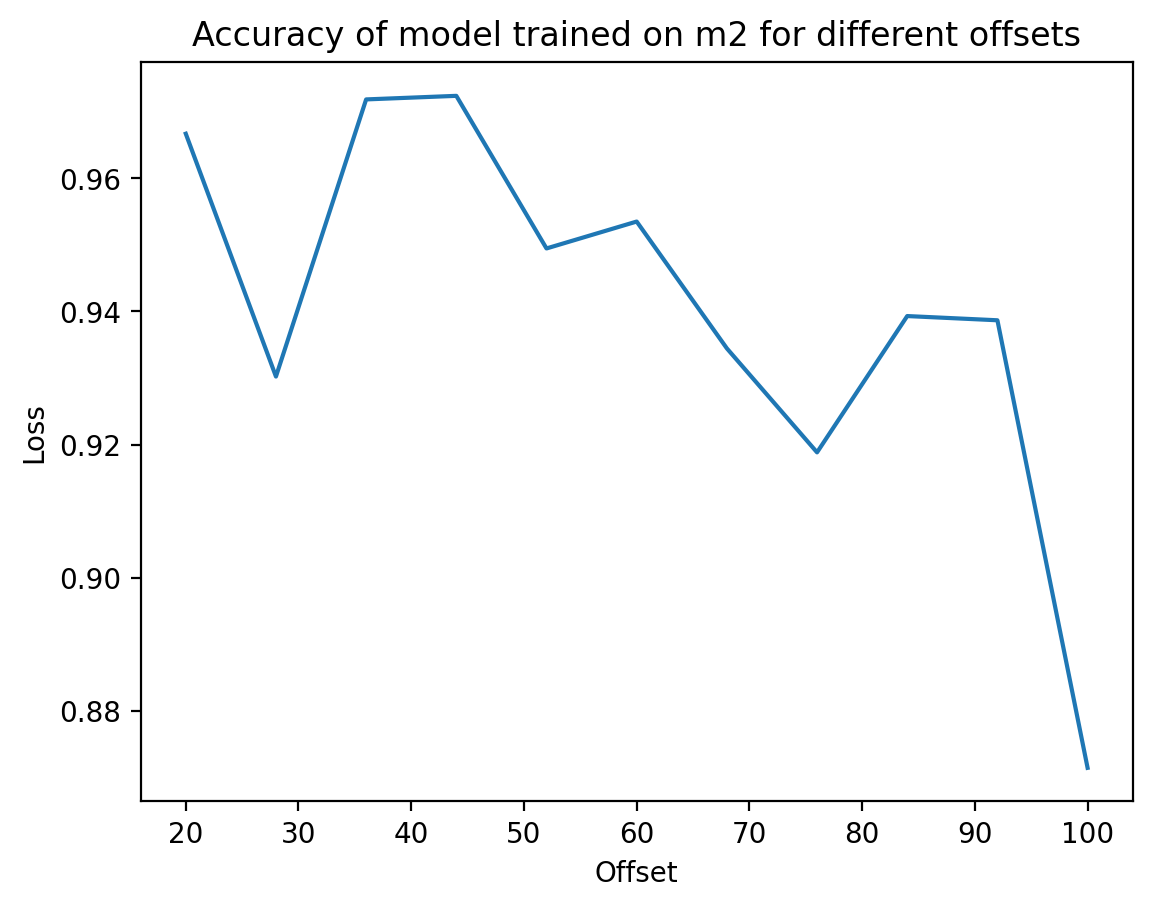

In [165]:
offsets = np.linspace(20,100,11)
windowSize = 50
costs = np.zeros(len(offsets))

for i in tqdm(range(len(offsets))):
    model, x2Input, y2Input, input_test, target_test, cost = train_model_m2(x2, y2, windowSize, offsets[i].astype(int))
    test_predict = model.predict(input_test)
    predicted_x2 = test_predict[:,0]
    predicted_y2 = test_predict[:,1]
    costs[i] = cost

fig, ax = plt.subplots()
ax.plot(offsets, costs)
ax.set_xlabel("Offset")
ax.set_ylabel("Loss")
ax.set_title("Accuracy of model trained on m2 for different offsets")

The accuracy of the model when trained using only the positions of m2 is much lower than when the positions of both masses are used. 